In [1]:
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

all_files = os.listdir("txt")
data = pd.DataFrame(columns=['id','content'])

for file in all_files:
    with open("txt/" + file, 'r', encoding='utf-8') as f:
        data.loc[len(data.index)] = [int(file.replace('.txt', '')), f.readlines()]        

In [2]:
import json

file_path = 'type.txt'

with open(file_path, 'r') as file:
    sources = json.load(file)

id_source = pd.DataFrame.from_dict(sources, orient='index').T.melt(var_name='source', value_name='id').dropna(subset=['id'])
data = pd.merge(data, id_source, on='id')
data.head()

,id,content,source
0,0,"[7/1/2021\n, https://www-proquest-com.falcon.l...",Boston Globe
1,1,"[7/2/2021\n, https://www-proquest-com.falcon.l...",Boston Globe
2,10,"[Find a copy\n, Abstract\n, document 1 of 1\n,...",Boston Globe
3,100,"[6/25/2021\n, https://www-proquest-com.falcon....",Others
4,101,"[6/25/2021\n, https://www-proquest-com.falcon....",Others


# STEP 1 : Data Cleaning

- get correct paragraph based on 'full text' and 'subject'
- delete URL and Chinese
- tokenizat
- stopwords removal
- pos tag -> lemmatization

In [3]:
empty_list_count = len(data[data['content'].apply(len) == 0])

print("The number of rows with an empty list in 'content':", empty_list_count)
data = data[data['content'].apply(len) > 0]

print("Removed rows with an empty list in 'content'.")

The number of rows with an empty list in 'content': 0
Removed rows with an empty list in 'content'.


In [4]:
import re
        
def get_clean_sentences(row):
    sentences = [sentence[:-1].lower() for sentence in row['content']]
    if "full text" in sentences:
        start_idx = sentences.index("full text")
        sentences = sentences[start_idx+1:]
    if "subject" in sentences:
        end_idx = sentences.index("subject")
        sentences = sentences[:end_idx]
        
    pattern_url = r'^https:\/\/'
    pattern_chinese = re.compile(r'[\u4e00-\u9fff]+') 
    result = [sentence for sentence in sentences if not re.search(pattern_url, sentence) and not re.search(pattern_chinese, sentence)]
    return result

data['clean_sentences'] = data.apply(get_clean_sentences, axis=1)

In [5]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN
    
def lemmatize(tokens):
    # find the pos tagginf for each tokens [('What', 'WP'), ('can', 'MD'), ('I', 'PRP') ....
    pos_tokens = nltk.pos_tag(tokens)
    
    # lemmatization using pos tag
    lemmatizer = WordNetLemmatizer()
    pos_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in pos_tokens]
    return pos_tokens

def remove_punctuation_only_strings(strings):
    punctuation_pattern = re.compile(r'^[^\w\s]+$')
    filtered_strings = [s for s in strings if not punctuation_pattern.match(s)]
    return filtered_strings

def tokenize(row):
    sentences = ''.join(row['clean_sentences'])
    words = word_tokenize(sentences)
    
    stops = stopwords.words('english')
    stops.extend(["'s","n't"])  
    words = [word for word in words if not word in stops]
    # words = [word for word in words if not word in set(stopwords.words('english'))]
    
    # words = [word for word in words if not all(char in string.punctuation for char in word)]
    words = remove_punctuation_only_strings(words)
    
    words = [word for word in words if len(word) != 1]
    
    words = lemmatize(words)
    return words


data['words'] = data.apply(tokenize, axis=1)
data.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,content,source,clean_sentences,words
0,0,"[7/1/2021\n, https://www-proquest-com.falcon.l...",Boston Globe,"[at china king last month, the phone rarely ra...","[china, king, last, month, phone, rarely, rang..."
1,1,"[7/2/2021\n, https://www-proquest-com.falcon.l...",Boston Globe,"[on wednesday morning, a newton south high sch...","[wednesday, morning, newton, south, high, scho..."
2,10,"[Find a copy\n, Abstract\n, document 1 of 1\n,...",Boston Globe,[when she first read the headlines from georgi...,"[first, read, headline, georgia, danielle, kim..."
3,100,"[6/25/2021\n, https://www-proquest-com.falcon....",Others,[the fbi warned of an increase in hate crimes ...,"[fbi, warn, increase, hate, crime, asian, amer..."
4,101,"[6/25/2021\n, https://www-proquest-com.falcon....",Others,[discrimination against china and chinese peop...,"[discrimination, china, chinese, people, nothi..."


# STEP 2 : TF-IDF

In [12]:
# 建立詞彙列表
word_list = list(set(word for document in data['words'] for word in document))

In [14]:
# 計算詞頻（TF）
def calculate_tf(word, document):
    return document.count(word) / len(document)

In [31]:
# 計算文件頻率（DF）
def calculate_df(word_matrix, word_list):
    df_matrix = []
    for document in word_matrix:
        word_dic = {}
        for word in word_list:
            if word in document:
                word_dic[word] = 1
            else:
                word_dic[word] = 0
        df_matrix.append(word_dic)
    return df_matrix


In [92]:
import json

# 計算逆文件頻率(IDF)
def calculate_idf(df_matrix):
    file_path = 'type.txt'
    with open(file_path, 'r') as file:
        sources = json.load(file)
    total_df = {}
    for docs in df_matrix:
        for key, df in docs.items():
            if key in total_df:
                total_df[key] = df + total_df[key]
            else:
                total_df[key] = df
        
    idf_matrix = {}        
    for key, docs in sources.items():
        print(key)
        value = {}
        for doc in docs:
            for k, df in df_matrix[doc].items():
                if k in value:
                    value[k] = df + value[k]
                else:
                    value[k] = df
        for k, df in value.items():
            value[k] = 2 + df/max(1,(total_df[k]-df))
        idf_matrix[key] = value 
    return idf_matrix
    

In [32]:
df_matrix = calculate_df(data['words'], word_list)

In [93]:
idf_matrix = calculate_idf(df_matrix)

Boston Globe
Chicago Tribune
LA Times
New York Times
News Magazines
Others
Star Tribune
USA Today
Washington Post


## loop

Boston Globe
['coordinate', 'danielle', 'small-business', 'celia', 'seaport.', 'hypersexual', 'warns', 'racismisavirus', 'pass.a', 'yun', 'edmonton', '44.regardless', 'tigertail', 'unwise', 'out.as', 'helstrom', 'intrusion', 'snarl', 'women.law', 'uy', 'psychologically', 'plaque', 'kim.', 'year.some', 'exotic.the', 'iamnotcovid19', 'co-host', 'soared.in', 'alain', 'wretched', 'prostitute', 'longer.historian', 'thespreading', 'hulu', 'carolinian', 'taunts/attacks', 'journal-constitution', 'winnie', 'data.for', 'awashington', 'doi/new', 'coffeehouse', 'fortunatelyin', 'adamant', 'outset', 'teenager.he', 'continued.the', 'exceptional', 'entrant', 'protagonist']


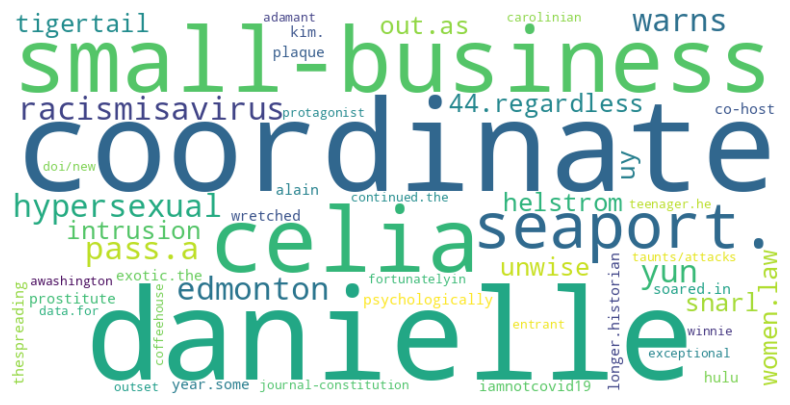

Chicago Tribune
['naperville', '14-year-old', 'buffalo', 'krieger', 'doug', 'forinformation', '1,100reports', 'rabbi', 'suicide', 'wild', 'asian-american.jews', 'virus.none', 'recreationalmarijuana', 'indo-american', 'nonprofit.photo', 'chinese.yes', 'wiesenthal', 'labelingcovid-19', 'hassan', 'singled', 'staffer', 'mecca', 'cyberbullying', 'arlington', 'meeting.bill', 'clipsto', 'wiesenthal.com.also', 'heroic', 'williambarr', 'reserved.7/3/20212/2', 'pangolin', 'ireport', 'do.i', 'eatbats', 'mediaplease', 'solano/usa', 'no.that', 'social-emotional', 'ablack', 'silent.for', 'theohio', 'ever.we', 'saidtwo', 'imagescredit', 'sundays', 'pandemic.chen', '7/3/20212/3', 'investigation.city', 'socialdistance', 'said.addressing']


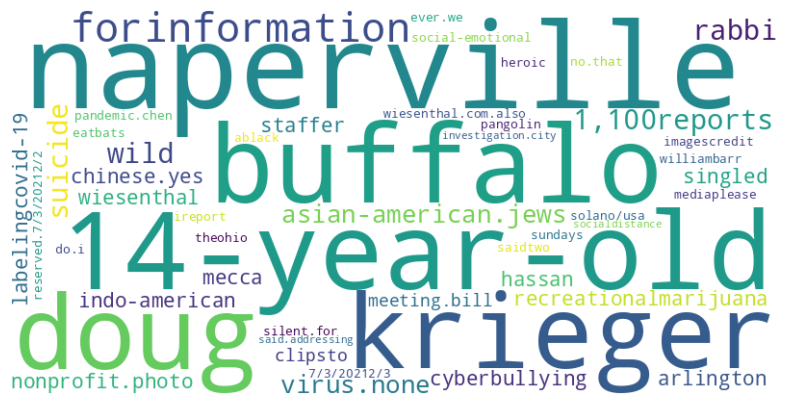

LA Times
['undergoing', 'wisconsin-madison', 'tune', '7/2/20212/3', 'suv', 'arson', 'theglobe', 'kosher', 'beforeand', 'cindy', 'footage.town', 'devkota.according', 'rabbi', 'workersduring', 'thebuddhist', 'wis.publication', 'hate.david', 'acts.last', 'needs.the', 'realnumber', 'ofjapanese-americans', 'runthe', 'cosgrove', 'walgreens', "we'reassimilated", 'htun', 'asian-american.jews', 'virus.none', 'delegation', 'shirley.leung', 'indo-american', 'nonprofit.photo', 'frustrated', 'telephone', 'antidefamation', 'to.', 'notfor', 'immigration-focused', 'others.', 'privateschools', 'rumors.despite', 'blame.', 'tobin', 'altar', 'wiesenthal', 'publicationmissoula', 'nicky', 'monsoon', 'shithole', 'shetakes']


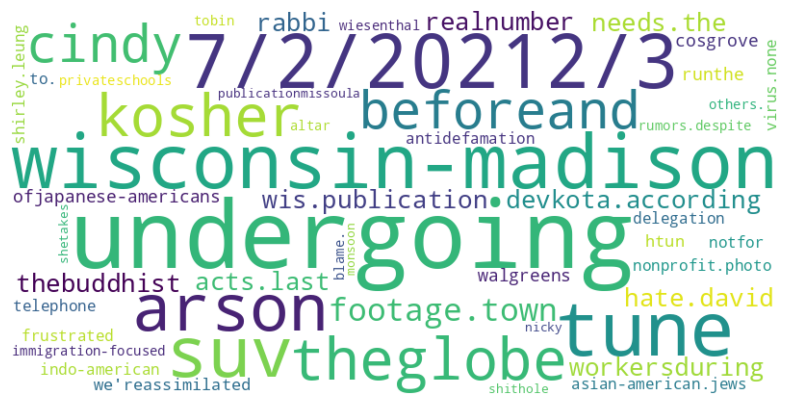

New York Times
['datemay', '91', 'force.as', 'hilliard', 'human-rights', 'wsj.comcredit', 'titlechina', 'insular', 'discrimination.between', 'influx', '248', 'guangzhou', '20207/4/20212/2locationchina', 'causing', '2019.the', 'determines', 'disable', 'accommodation.hate', 'raid', 'co-op', 'longer-term', 'adam', 'caller', 'cbc', 'backstory.racism', '15.', 'herring', 'or7/4/20214/72019', 'deterioration', 'islam', 'hyperbole', 'alsodrawing', 'abstraction.mr', 'mindset.it', 'sapnaraj', 'us.mayzhou', 'brotherhood', 'physical.a', 'leshuo', 'lankaseveral', 'towardswhat', 'in', 'againstharmful', 'busload', 'defining', 'frombusinesses', 'receivesdozens.senior', 'vent.', 'embark', 'thatway']


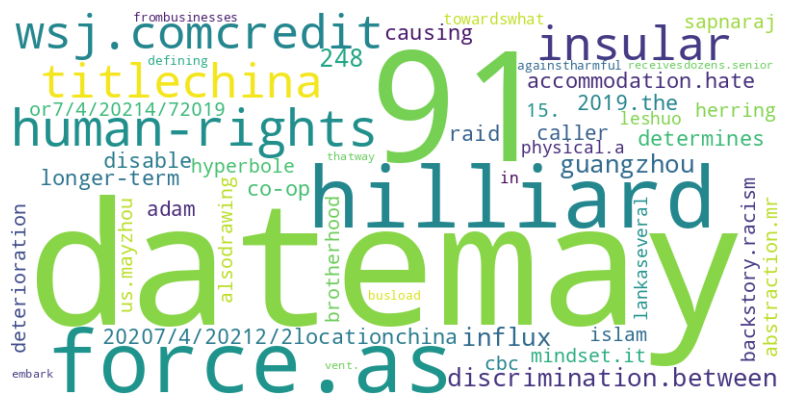

News Magazines
['barley', 'anti-asiansentiment', 'borundacopyright', 'process.the', 'simonson', '19called', 'government.daniel', 'urlmexico/docview/2396591565/se-2', "'chineseexport", '1,732', 'investigation7/6/20212/4morrison', 'racialised', 'resided', 'allacts', 'hygienic', 'wine-maker', 'economicmight', 'dborunda', 'updated2020-05-26databaseglobal', 'transparencyfrom', 'chinese-australian', 'arrests.chihuahua', 'unsolved', 'elpasotimes.com', 'marketat', 'issue.prime', 'non-discriminatory', 'twitter.credit', 'isunhappy', 'timecoming', 'hereon', 'deputysheriff', 'acritical', 'ofinvasion', "'white", 'idn', 'probe.though', 'youspend', 'napervillecontinues', 'wujie', 'undertaken', 'whataustralia', 'wasrefusing', 'urlmoves/docview/2406664306/se-2', 'recklessly', 'seaforces', 'thesupport', 'soaustralian', 'reported.though', 'substantialproposals']


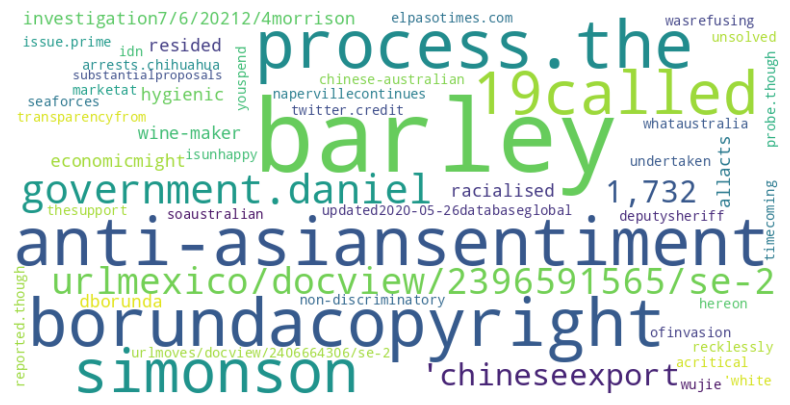

Others
['2020.', '2021-04', 'issn', 'amnews', '3aethnicnewswatch', 'asamnews', 'born', 'tool', 'self', 'stomp', 'laugh', 'commit', 'engage', 'attitude', 'nature', 'suddenly', 'degree', 'pew', 'terrible', 'promise', 'seat', 'interaction', 'demonstrate', 'pack', 'path', 'collection', 'poll', 'skin', 'motivation', 'gannett', 'rft_val_fmt=info', 'everyday', 'imagine', 'ofi/fmt', 'gold', 'energy', '61-year-old', 'preliminary', 'square', 'license', 'emotional', 'vehicle', 'hurl', 'paper', 'hopeful', 'option', 'honor', 'mandate', 'scared', '200']


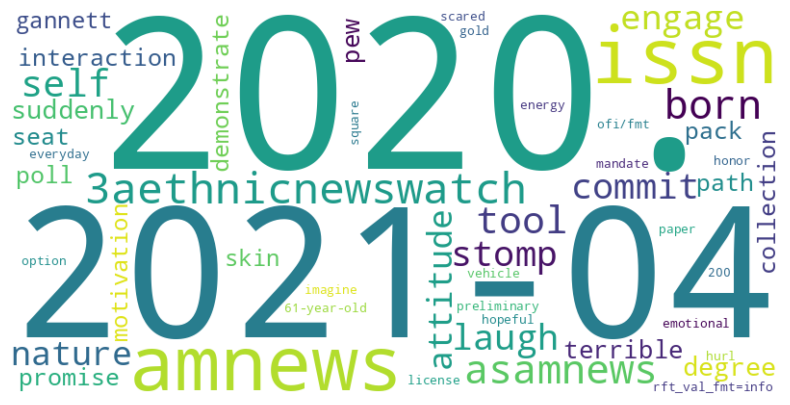

Star Tribune
['distrustful', 'said.kim', 'flip', 'overdrive', '69xiaojie', 'data.according', 'canbe', 'lower-wage', 'ahollowed-out', 'tothem.parents', 'largestfirefox', 'portrayed.this', 'excused.', 'fragility', 'tntp', 'toremote', 'julia', 'reporterson', 'hj', 'programs.', 'a.13', 'heldsigns', 'classrooms', 'dialect', 'kim38', 'criminal.', 'asingle', 'hatta', 'quarantined.lirazan', 'mariah', 'areblack', 'support.firefoxwhile', 'sherecovered', 'reassign', 'recognitionfrom', 'upwith', 'schooloutside', 'jaycollege', 'sahan', 'gwatney', 'thattrump', '33paul', 'thedemonstrations', 'pushedthe', 'moreresilient', 'sowe', 'unemployment.the', 'crisis.the', '31.of', 'reallyhard']


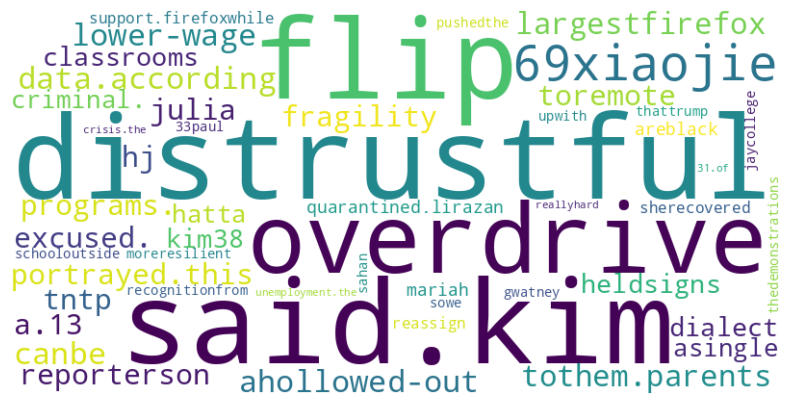

USA Today
['galvanize', 'precinct', 'mott', 'correction', '3anytimes', 'spreadsheet', 'equip', 'connects', 'tempt', 'alexandra', 'redfield', 'curtis', 'petri', 'prolonged', 'carried', 'dozens', 'landscape', 'strategist', 'pilot', '3bbromwich', 'ithas', 'tandem', 'adjacent', 'race.but', 'catching', 'fin', '6/24/20212/2', 'chinavirus', 'force.for', 'permeates', 'crime-fighting', 'matter.in', 'fails', 'watchful', 'throes', 'plainclothes', 'roves', 'hiv', 'whenarrests', 'filmmaker', 'accosted', 'avenue.a', 'sounding', 'beret', 'ness', 'reoccur.the', 'mikecompany', 'fired.after', 'williamsburg', '5bnational']


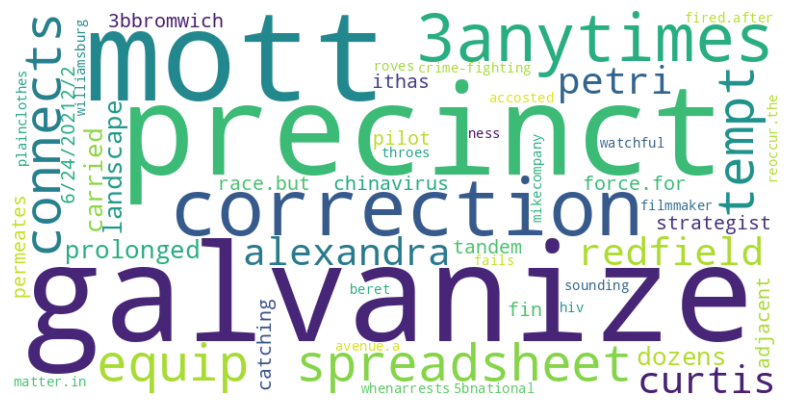

Washington Post
['stigmatisation', 'close-up', '923120publication', 'mers', 'iamnotavirus', 'onmonday', 'cornyn', 'shrimp', '\xadontario', 'grade-school-age', 'whitesand', 'family.the', 'freelance', '\xadadministration', '725-unit', '350', '\xadaffluentneighbourhoods', 'sacrificedtheir', 'andanti-chinese', 'filming', 'indulge', 'andbeyond', 'bayfirst', 'logistics', 'hearken', 'communicator', 'cream.so', '9,000', 'libbycompany', 'racismauthormin-young', 'todayis', 'train.copyright', 'chinais', 'wand', 'severalof', "'not", 'smarta', 'nonpartisannews', 'nevercalled', 'once.it', 'beleaguer', 'id:2368028956document', 'movingaway', 'onthese', 'devote', "'earlier", 'scourge', 'actuallyinvolve', 'baycountry', 'heel']


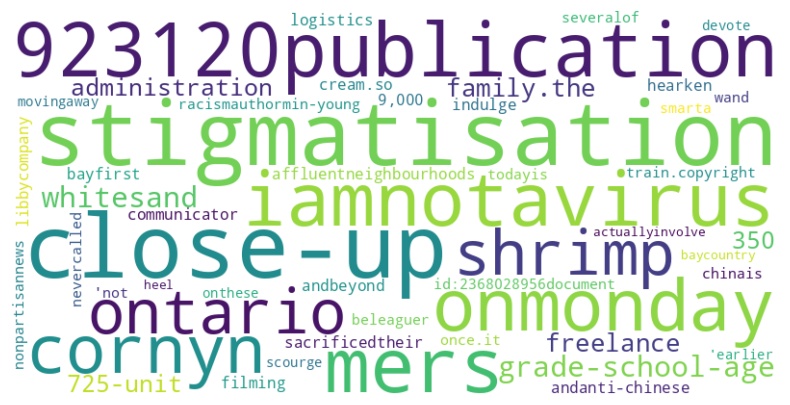

In [94]:
for key, idf in idf_matrix.items():
    print(key)
    # 按值对字典进行排序，并选择前 20 个
    sorted_idf = dict(sorted(idf.items(), key=lambda item: item[1], reverse=True)[:50])
    top50 = []
    for k, value in sorted_idf.items():
        top50.append(k)
    print(top50)
    # 创建一个 WordCloud 对象，并传入排序后的字典作为参数
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_idf)
    # 绘制文字云
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
